# I. Librairies

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.0.0
Num GPUs Available: 1


In [3]:
from generalBDDHandler import GeneralBDDHandler
from generalIOLib import FlatInputDic, GeneralOutputLib
from datasets.BatchGenerator import BatchGenerator

In [4]:
random_seed = 42

## II Description

In [5]:
general_bdd = pd.read_csv('datasets/generalIO_v2.csv', usecols = ['match_id','output'], delimiter = ";")
print(f"number of samples: {general_bdd.shape[0]}, number of matches : {len(np.unique(general_bdd['match_id']))}")

number of samples: 121536, number of matches : 503


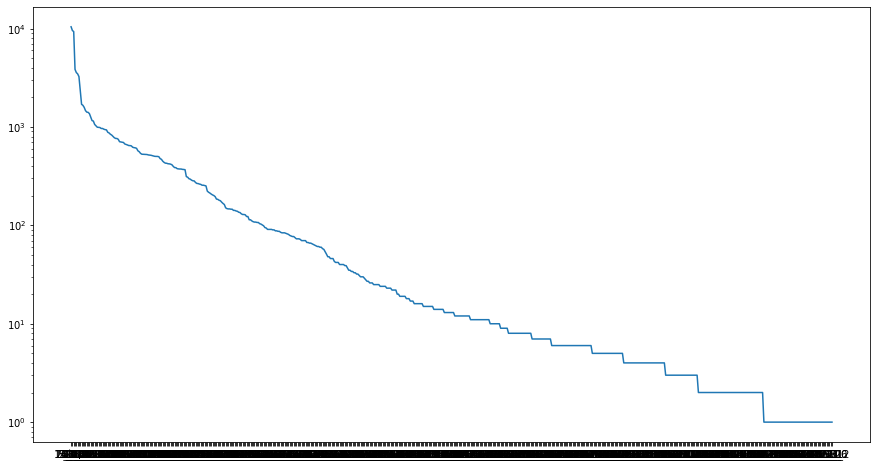

In [6]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

ax.plot(general_bdd['output'].value_counts(), label = 'member count per class')

ax.set_yscale('log')
plt.show()

## III Batch Generator

In [7]:
batch_size = 512
train_split = 0.8
batch_generator = BatchGenerator("datasets/generalIO_v2.csv", batch_size, train_split, random_seed )

# IV Model

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten, Conv2D, Activation, MaxPooling2D, BatchNormalization,concatenate
from tensorflow.keras.optimizers import Adam

In [18]:
flatInputLib = FlatInputDic()
generalOutputLib = GeneralOutputLib()
def create_MLP_CNN():
    
    mlp_inputs = Input(shape = (7,), name = 'mlp')
    cnn_inputs = Input(shape = (29,15,7), name = 'cnn')
    
    #mlp model
    mlp_core = Dense(8, activation = 'relu')(mlp_inputs)
    mlp_core = Dense(8, activation = 'relu')(mlp_core)
    
    #cnn model
    cnn_core = Conv2D(32, (3, 3), activation='relu', padding = 'same')(cnn_inputs)
    cnn_core = MaxPooling2D((2, 2))(cnn_core)
    cnn_core = Conv2D(64, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = MaxPooling2D((2, 2))(cnn_core)
    cnn_core = Conv2D(64, (3, 3), activation='relu', padding = 'same')(cnn_core)
    cnn_core = Flatten()(cnn_core)
    
    #assembly
    x = concatenate([mlp_core, cnn_core])
    
    #dense end
    x = Dense(generalOutputLib.index, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(generalOutputLib.index, activation = 'relu')(x)
    output = Dense(generalOutputLib.index, activation = 'softmax')(x)
    
    
    #model
    model = Model(inputs = [mlp_inputs, cnn_inputs], outputs = [output])
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn (InputLayer)                [(None, 29, 15, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 29, 15, 32)   2048        cnn[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 14, 7, 32)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 7, 64)    18496       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

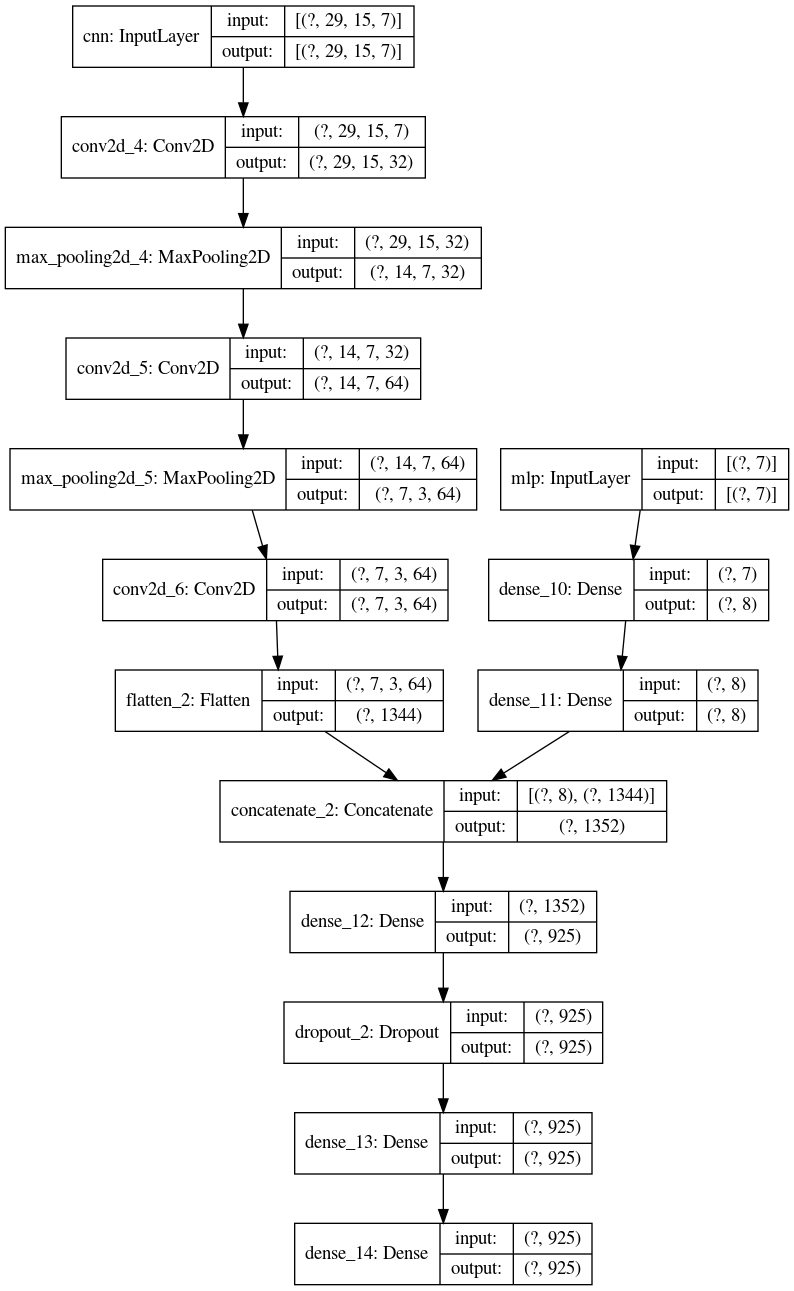

In [19]:
model = create_MLP_CNN()
print(model.summary())
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [11]:
optimizer = tf.optimizers.SGD(learning_rate = 1e-3)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')

In [12]:
# define metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy() 

In [13]:
# define training and evaluation steps
@tf.function
def forward(features, training=False):
    predictions = model.call(features[0], training=training)
    loss = tf.losses.categorical_crossentropy(
            y_true=features[1],
            y_pred=predictions)
    return loss, predictions

@tf.function
def train_step(features):
    with tf.GradientTape() as tape:
        loss, predictions = forward(features, training=True)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def evaluate(features, step):
    loss, predictions = forward(features)
    _ = train_accuracy.update_state(features[1], predictions)
    train_loss(loss)
    template = "step: {} - train loss/acc: {:.3f}/{:2.2%}"
    print(template.format(step,train_loss.result(), train_accuracy.result()))

## V Training

In [15]:
n_epochs = 20
for i in range(n_epochs):
    for flat_inputs, images, outputs in batch_generator.getBatches():
        train_step(((flat_inputs,images), outputs))
        evaluate(((flat_inputs,images), outputs), 0)

step: 0 - train loss/acc: 4.476/9.77%
step: 0 - train loss/acc: 4.457/11.91%
step: 0 - train loss/acc: 4.453/13.35%
step: 0 - train loss/acc: 4.455/13.28%
step: 0 - train loss/acc: 4.470/11.84%
step: 0 - train loss/acc: 4.452/12.24%
step: 0 - train loss/acc: 4.467/11.36%
step: 0 - train loss/acc: 4.429/11.43%
step: 0 - train loss/acc: 4.407/11.85%
step: 0 - train loss/acc: 4.364/12.21%
step: 0 - train loss/acc: 4.366/12.43%
step: 0 - train loss/acc: 4.370/11.96%
step: 0 - train loss/acc: 4.485/11.88%
step: 0 - train loss/acc: 4.540/11.90%
step: 0 - train loss/acc: 4.641/11.61%
step: 0 - train loss/acc: 4.690/11.50%
step: 0 - train loss/acc: 4.760/11.45%
step: 0 - train loss/acc: 4.770/11.30%
step: 0 - train loss/acc: 4.788/11.11%
step: 0 - train loss/acc: 4.766/11.51%
step: 0 - train loss/acc: 4.761/11.86%
step: 0 - train loss/acc: 4.747/11.85%
step: 0 - train loss/acc: 4.745/11.68%
step: 0 - train loss/acc: 4.736/11.59%
step: 0 - train loss/acc: 4.717/11.89%
step: 0 - train loss/acc: 

step: 0 - train loss/acc: 4.366/12.79%
step: 0 - train loss/acc: 4.363/12.79%
step: 0 - train loss/acc: 4.363/12.83%
step: 0 - train loss/acc: 4.361/12.83%
step: 0 - train loss/acc: 4.360/12.83%
step: 0 - train loss/acc: 4.362/12.81%
step: 0 - train loss/acc: 4.359/12.82%
step: 0 - train loss/acc: 4.357/12.86%
step: 0 - train loss/acc: 4.355/12.87%
step: 0 - train loss/acc: 4.353/12.88%
step: 0 - train loss/acc: 4.351/12.88%
step: 0 - train loss/acc: 4.356/12.85%
step: 0 - train loss/acc: 4.353/12.86%
step: 0 - train loss/acc: 4.349/12.86%
step: 0 - train loss/acc: 4.346/12.90%
step: 0 - train loss/acc: 4.345/12.91%
step: 0 - train loss/acc: 4.344/12.89%
step: 0 - train loss/acc: 4.342/12.89%
step: 0 - train loss/acc: 4.342/12.93%
step: 0 - train loss/acc: 4.341/12.93%
step: 0 - train loss/acc: 4.339/12.94%
step: 0 - train loss/acc: 4.337/12.95%
step: 0 - train loss/acc: 4.336/12.95%
step: 0 - train loss/acc: 4.334/12.96%
step: 0 - train loss/acc: 4.333/12.96%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 4.248/14.23%
step: 0 - train loss/acc: 4.246/14.24%
step: 0 - train loss/acc: 4.245/14.25%
step: 0 - train loss/acc: 4.247/14.25%
step: 0 - train loss/acc: 4.247/14.26%
step: 0 - train loss/acc: 4.246/14.27%
step: 0 - train loss/acc: 4.244/14.28%
step: 0 - train loss/acc: 4.242/14.28%
step: 0 - train loss/acc: 4.240/14.29%
step: 0 - train loss/acc: 4.238/14.29%
step: 0 - train loss/acc: 4.236/14.29%
step: 0 - train loss/acc: 4.235/14.29%
step: 0 - train loss/acc: 4.233/14.28%
step: 0 - train loss/acc: 4.232/14.29%
step: 0 - train loss/acc: 4.230/14.30%
step: 0 - train loss/acc: 4.228/14.31%
step: 0 - train loss/acc: 4.226/14.32%
step: 0 - train loss/acc: 4.224/14.33%
step: 0 - train loss/acc: 4.222/14.33%
step: 0 - train loss/acc: 4.221/14.34%
step: 0 - train loss/acc: 4.219/14.35%
step: 0 - train loss/acc: 4.218/14.37%
step: 0 - train loss/acc: 4.216/14.37%
step: 0 - train loss/acc: 4.215/14.39%
step: 0 - train loss/acc: 4.216/14.38%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 4.115/15.27%
step: 0 - train loss/acc: 4.114/15.26%
step: 0 - train loss/acc: 4.112/15.27%
step: 0 - train loss/acc: 4.111/15.28%
step: 0 - train loss/acc: 4.111/15.29%
step: 0 - train loss/acc: 4.111/15.29%
step: 0 - train loss/acc: 4.109/15.30%
step: 0 - train loss/acc: 4.108/15.32%
step: 0 - train loss/acc: 4.107/15.33%
step: 0 - train loss/acc: 4.107/15.32%
step: 0 - train loss/acc: 4.106/15.32%
step: 0 - train loss/acc: 4.104/15.33%
step: 0 - train loss/acc: 4.103/15.34%
step: 0 - train loss/acc: 4.102/15.35%
step: 0 - train loss/acc: 4.101/15.36%
step: 0 - train loss/acc: 4.100/15.38%
step: 0 - train loss/acc: 4.099/15.38%
step: 0 - train loss/acc: 4.098/15.39%
step: 0 - train loss/acc: 4.097/15.39%
step: 0 - train loss/acc: 4.095/15.40%
step: 0 - train loss/acc: 4.094/15.42%
step: 0 - train loss/acc: 4.092/15.44%
step: 0 - train loss/acc: 4.090/15.45%
step: 0 - train loss/acc: 4.088/15.48%
step: 0 - train loss/acc: 4.086/15.50%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 3.926/17.18%
step: 0 - train loss/acc: 3.925/17.19%
step: 0 - train loss/acc: 3.924/17.20%
step: 0 - train loss/acc: 3.923/17.22%
step: 0 - train loss/acc: 3.922/17.22%
step: 0 - train loss/acc: 3.920/17.23%
step: 0 - train loss/acc: 3.919/17.24%
step: 0 - train loss/acc: 3.918/17.26%
step: 0 - train loss/acc: 3.916/17.28%
step: 0 - train loss/acc: 3.915/17.29%
step: 0 - train loss/acc: 3.915/17.30%
step: 0 - train loss/acc: 3.913/17.31%
step: 0 - train loss/acc: 3.912/17.33%
step: 0 - train loss/acc: 3.910/17.36%
step: 0 - train loss/acc: 3.908/17.38%
step: 0 - train loss/acc: 3.907/17.39%
step: 0 - train loss/acc: 3.906/17.39%
step: 0 - train loss/acc: 3.906/17.41%
step: 0 - train loss/acc: 3.904/17.42%
step: 0 - train loss/acc: 3.903/17.43%
step: 0 - train loss/acc: 3.902/17.45%
step: 0 - train loss/acc: 3.900/17.46%
step: 0 - train loss/acc: 3.899/17.47%
step: 0 - train loss/acc: 3.898/17.49%
step: 0 - train loss/acc: 3.897/17.50%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 3.728/19.57%
step: 0 - train loss/acc: 3.727/19.57%
step: 0 - train loss/acc: 3.726/19.58%
step: 0 - train loss/acc: 3.724/19.60%
step: 0 - train loss/acc: 3.722/19.62%
step: 0 - train loss/acc: 3.721/19.64%
step: 0 - train loss/acc: 3.719/19.66%
step: 0 - train loss/acc: 3.718/19.68%
step: 0 - train loss/acc: 3.716/19.70%
step: 0 - train loss/acc: 3.715/19.72%
step: 0 - train loss/acc: 3.713/19.75%
step: 0 - train loss/acc: 3.712/19.77%
step: 0 - train loss/acc: 3.710/19.79%
step: 0 - train loss/acc: 3.708/19.81%
step: 0 - train loss/acc: 3.707/19.84%
step: 0 - train loss/acc: 3.705/19.86%
step: 0 - train loss/acc: 3.703/19.89%
step: 0 - train loss/acc: 3.702/19.91%
step: 0 - train loss/acc: 3.700/19.93%
step: 0 - train loss/acc: 3.699/19.95%
step: 0 - train loss/acc: 3.697/19.97%
step: 0 - train loss/acc: 3.696/19.99%
step: 0 - train loss/acc: 3.695/20.01%
step: 0 - train loss/acc: 3.693/20.03%
step: 0 - train loss/acc: 3.692/20.05%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 3.675/21.88%
step: 0 - train loss/acc: 3.676/21.87%
step: 0 - train loss/acc: 3.676/21.87%
step: 0 - train loss/acc: 3.676/21.87%
step: 0 - train loss/acc: 3.677/21.86%
step: 0 - train loss/acc: 3.677/21.85%
step: 0 - train loss/acc: 3.678/21.84%
step: 0 - train loss/acc: 3.679/21.83%
step: 0 - train loss/acc: 3.679/21.82%
step: 0 - train loss/acc: 3.680/21.82%
step: 0 - train loss/acc: 3.680/21.81%
step: 0 - train loss/acc: 3.681/21.80%
step: 0 - train loss/acc: 3.682/21.79%
step: 0 - train loss/acc: 3.683/21.78%
step: 0 - train loss/acc: 3.684/21.77%
step: 0 - train loss/acc: 3.684/21.76%
step: 0 - train loss/acc: 3.685/21.75%
step: 0 - train loss/acc: 3.685/21.75%
step: 0 - train loss/acc: 3.686/21.75%
step: 0 - train loss/acc: 3.686/21.74%
step: 0 - train loss/acc: 3.686/21.74%
step: 0 - train loss/acc: 3.686/21.74%
step: 0 - train loss/acc: 3.687/21.73%
step: 0 - train loss/acc: 3.687/21.72%
step: 0 - train loss/acc: 3.688/21.71%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 3.760/20.62%
step: 0 - train loss/acc: 3.761/20.61%
step: 0 - train loss/acc: 3.761/20.60%
step: 0 - train loss/acc: 3.762/20.60%
step: 0 - train loss/acc: 3.763/20.59%
step: 0 - train loss/acc: 3.764/20.58%
step: 0 - train loss/acc: 3.764/20.58%
step: 0 - train loss/acc: 3.765/20.57%
step: 0 - train loss/acc: 3.766/20.56%
step: 0 - train loss/acc: 3.766/20.56%
step: 0 - train loss/acc: 3.766/20.56%
step: 0 - train loss/acc: 3.767/20.55%
step: 0 - train loss/acc: 3.767/20.54%
step: 0 - train loss/acc: 3.768/20.54%
step: 0 - train loss/acc: 3.768/20.54%
step: 0 - train loss/acc: 3.768/20.53%
step: 0 - train loss/acc: 3.769/20.52%
step: 0 - train loss/acc: 3.769/20.51%
step: 0 - train loss/acc: 3.769/20.51%
step: 0 - train loss/acc: 3.770/20.50%
step: 0 - train loss/acc: 3.770/20.50%
step: 0 - train loss/acc: 3.770/20.49%
step: 0 - train loss/acc: 3.771/20.49%
step: 0 - train loss/acc: 3.772/20.48%
step: 0 - train loss/acc: 3.772/20.47%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 3.821/19.69%
step: 0 - train loss/acc: 3.821/19.68%
step: 0 - train loss/acc: 3.821/19.68%
step: 0 - train loss/acc: 3.822/19.68%
step: 0 - train loss/acc: 3.822/19.68%
step: 0 - train loss/acc: 3.822/19.68%
step: 0 - train loss/acc: 3.823/19.67%
step: 0 - train loss/acc: 3.823/19.67%
step: 0 - train loss/acc: 3.823/19.67%
step: 0 - train loss/acc: 3.824/19.66%
step: 0 - train loss/acc: 3.824/19.66%
step: 0 - train loss/acc: 3.824/19.66%
step: 0 - train loss/acc: 3.824/19.66%
step: 0 - train loss/acc: 3.824/19.66%
step: 0 - train loss/acc: 3.824/19.65%
step: 0 - train loss/acc: 3.824/19.64%
step: 0 - train loss/acc: 3.825/19.64%
step: 0 - train loss/acc: 3.825/19.64%
step: 0 - train loss/acc: 3.825/19.64%
step: 0 - train loss/acc: 3.826/19.63%
step: 0 - train loss/acc: 3.826/19.62%
step: 0 - train loss/acc: 3.826/19.62%
step: 0 - train loss/acc: 3.827/19.61%
step: 0 - train loss/acc: 3.827/19.61%
step: 0 - train loss/acc: 3.827/19.60%
step: 0 - train loss/acc:

step: 0 - train loss/acc: 3.869/18.97%
step: 0 - train loss/acc: 3.869/18.96%
step: 0 - train loss/acc: 3.869/18.96%
step: 0 - train loss/acc: 3.869/18.96%
step: 0 - train loss/acc: 3.869/18.96%
step: 0 - train loss/acc: 3.869/18.95%
step: 0 - train loss/acc: 3.870/18.95%
step: 0 - train loss/acc: 3.870/18.95%
step: 0 - train loss/acc: 3.870/18.95%
step: 0 - train loss/acc: 3.870/18.94%
step: 0 - train loss/acc: 3.870/18.94%
step: 0 - train loss/acc: 3.871/18.94%
step: 0 - train loss/acc: 3.871/18.93%
step: 0 - train loss/acc: 3.871/18.93%
step: 0 - train loss/acc: 3.871/18.93%
step: 0 - train loss/acc: 3.871/18.93%
step: 0 - train loss/acc: 3.871/18.92%
step: 0 - train loss/acc: 3.872/18.92%
step: 0 - train loss/acc: 3.873/18.91%
step: 0 - train loss/acc: 3.874/18.91%
step: 0 - train loss/acc: 3.875/18.90%
step: 0 - train loss/acc: 3.876/18.90%
step: 0 - train loss/acc: 3.876/18.89%
step: 0 - train loss/acc: 3.877/18.89%
step: 0 - train loss/acc: 3.877/18.89%
step: 0 - train loss/acc:

Process ForkPoolWorker-11:
Traceback (most recent call last):
  File "/home/etiennew/anaconda3/envs/tensorflow_gpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/etiennew/anaconda3/envs/tensorflow_gpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


step: 0 - train loss/acc: 3.897/18.65%


  File "/home/etiennew/anaconda3/envs/tensorflow_gpu/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/media/etiennew/D:/Documents/Programmation/GitE/AlphaTerminal/datasets/BatchGenerator.py", line 103, in _constructAsync
    flat_input, image, output_vec = self.convertSample(samples[0])


KeyboardInterrupt: 

  File "/media/etiennew/D:/Documents/Programmation/GitE/AlphaTerminal/datasets/BatchGenerator.py", line 81, in convertSample
    image = self.generalBDDHandler.getImage(units_list)
  File "/media/etiennew/D:/Documents/Programmation/GitE/AlphaTerminal/generalBDDHandler.py", line 74, in getImage
    image[u][v][unit_type] += convertStability(unit_type,stability, uint8) #+= is here to stack information units
KeyboardInterrupt
